In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt
import sys
import random

from itertools import product

from Data_Loading import *
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import PolynomialFeatures

b


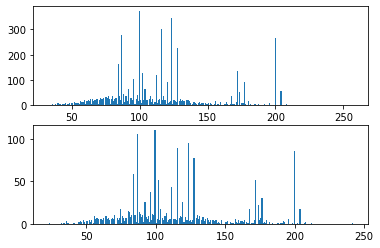

In [2]:
main_df = pd.read_csv('Banco de Dados/atributos/atributos_main.csv', index_col=0)

main_df['bpm'] = main_df['bpm'].apply(lambda bpm: round(bpm*2)/2)

X = main_df.iloc[:, :66]
y = main_df.iloc[:, [66]]
X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train = y_train.values.reshape(-1,)
y_test = y_test.values.reshape(-1,)

plt.subplot(2,1,1)
plt.hist(y_train, bins = 273)
plt.subplot(2,1,2)
plt.hist(y_test, bins = 273)
plt.show()

In [ ]:
dicio = {}

for bpm in main_df['bpm'].unique():
    dicio[bpm] = main_df[main_df['bpm'] == bpm]



In [ ]:
sizes = []
for lab, bpm_list in dicio.items():
    sizes.append(len(bpm_list))
   

small = [size for size in sizes if size<10]
sum(small)

In [3]:
random_df = main_df.sample(frac=1)
dicio = {}

for bpm in random_df['bpm'].unique():
    dicio[bpm] = random_df[random_df['bpm'] == bpm]

   

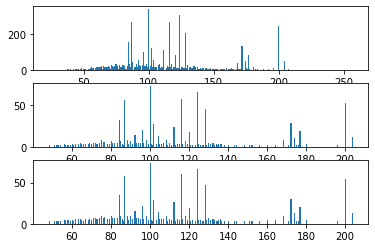

In [4]:
     
train = pd.DataFrame()
cv = pd.DataFrame()
test = pd.DataFrame()

first = True

for lab, bpm_list in dicio.items():
    if(len(bpm_list)<10):
        train = pd.concat([train, bpm_list], axis=0)
    else:
        train_size = int(0.7*len(bpm_list))
        cv_size = int(0.15*len(bpm_list))
        test_size = int(0.15*len(bpm_list))
        
        train_set = bpm_list.iloc[:train_size]
        cv_set = bpm_list.iloc[train_size-1:train_size+cv_size]
        test_set = bpm_list.iloc[train_size+cv_size-1:]
        
        train = pd.concat([train, train_set], axis=0)
        cv = pd.concat([cv, cv_set], axis=0)
        test = pd.concat([test, test_set], axis=0)
        
        
X_train = train.iloc[:, :66]
y_train = train.iloc[:, [66]]

X_cv = cv.iloc[:, :66]
y_cv = cv.iloc[:, [66]]

X_test = test.iloc[:, :66]
y_test = test.iloc[:, [66]]


y_train = y_train.values.reshape(-1,)
y_cv = y_cv.values.reshape(-1,)
y_test = y_test.values.reshape(-1,)

plt.subplot(3,1,1)
plt.hist(y_train, bins = 273)
plt.subplot(3,1,2)
plt.hist(y_cv, bins = 273)
plt.subplot(3,1,3)
plt.hist(y_test, bins = 273)
plt.show()

In [5]:
X_train_std = StandardScaler().fit_transform(X_train)
X_cv_std = StandardScaler().fit_transform(X_cv)
X_test_std = StandardScaler().fit_transform(X_test)


results_df = pd.DataFrame({"Espaço":[],
                           "Train_loss_array":[], "Train_loss":[],
                           "CV_loss_array":[], "CV_loss":[],
                           "Test_loss_array":[], "Test_loss":[],
                           "num_iter":[], "time_elapsed":[]})



#alpha, 
alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
layer_sizes = [(3,), (3,3), (5,), (5,5), (7,), (7,7), (9,), (9,9)]

max_iter = 4000

params_space = list(product(alphas, learning_rates, layer_sizes))
params_num = len(params_space)
cur_param = 0

In [6]:
for space_i, space in enumerate(params_space):
    start = time.time()
    mlp = MLPRegressor(alpha = space[0], learning_rate_init = space[1], hidden_layer_sizes = space[2], warm_start = True)
    train_error = []
    cv_error = []
    test_error = []
    
    times = 0
    for i in range(max_iter):
        mlp.partial_fit(X_train_std, y_train)
        train_loss = mean_squared_error(mlp.predict(X_train_std), y_train)
        
        if i>0:
            if (train_error[-1] - train_loss)<0.0001:
                times  = times + 1
                if times >=5:
                    sys.stdout.flush()
                    print(f'Espaço de Parâmetros {space_i}: {space} - Treinamento encerrado por evolução aceitável: {i} iterações | erro={round(train_loss,3)}!')
                    break
            else:
                times = 0
        
        train_error.append(train_loss)
        cv_error.append(mean_squared_error(mlp.predict(X_cv_std), y_cv))
        test_error.append(mean_squared_error(mlp.predict(X_test_std), y_test))
        
        print(f'Espaço de Parâmetros {space_i} {space} - Iterações realizadas: {i} - Train_loss: {train_loss}', end='\r')
        
        if i==max_iter-1:
            sys.stdout.flush()
            print(f'Espaço de Parâmetros {space_i}: {space} - Treinamento encerrado por máximo de iterações: {max_iter}!')
    
    end = time.time()
    
    
    this_dict = {"Espaço":[], "Layers":[], "Train_loss_array":[], "CV_loss_array":[], "Test_loss_array":[]}
    this_dict["Index"] = space_i
    this_dict["Espaço"].append(space)
    this_dict["Alpha"] = space[0]
    this_dict["Learning Rate"] = space[1]
    this_dict["Layers"].append(space[2])
    this_dict["Train_loss_array"].append(train_error)
    this_dict["Train_loss"] = float(train_error[-1])
    this_dict["CV_loss_array"].append(cv_error)
    this_dict["CV_loss"] = float(cv_error[-1])
    this_dict["Test_loss_array"].append(test_error)
    this_dict["Test_loss"] = float(test_error[-1])
    this_dict["num_iter"] = i
    this_dict["time_elapsed"] = (end-start)/60
    
    
    results_df = pd.concat([results_df, pd.DataFrame(this_dict)])

Espaço de Parâmetros 0: (0.001, 0.001, (3,)) - Treinamento encerrado por máximo de iterações: 4000!048754
Espaço de Parâmetros 1: (0.001, 0.001, (3, 3)) - Treinamento encerrado por evolução aceitável: 1128 iterações | erro=1067.497!
Espaço de Parâmetros 2: (0.001, 0.001, (5,)) - Treinamento encerrado por evolução aceitável: 1288 iterações | erro=985.885!
Espaço de Parâmetros 3: (0.001, 0.001, (5, 5)) - Treinamento encerrado por evolução aceitável: 2003 iterações | erro=894.781!
Espaço de Parâmetros 4: (0.001, 0.001, (7,)) - Treinamento encerrado por evolução aceitável: 1505 iterações | erro=905.975!
Espaço de Parâmetros 5: (0.001, 0.001, (7, 7)) - Treinamento encerrado por evolução aceitável: 3948 iterações | erro=827.261!
Espaço de Parâmetros 6: (0.001, 0.001, (9,)) - Treinamento encerrado por evolução aceitável: 939 iterações | erro=937.88!
Espaço de Parâmetros 7: (0.001, 0.001, (9, 9)) - Treinamento encerrado por evolução aceitável: 1569 iterações | erro=815.054!
Espaço de Parâmetro

Espaço de Parâmetros 66: (0.003, 0.01, (5,)) - Treinamento encerrado por evolução aceitável: 409 iterações | erro=929.795!
Espaço de Parâmetros 67: (0.003, 0.01, (5, 5)) - Treinamento encerrado por evolução aceitável: 558 iterações | erro=915.65!
Espaço de Parâmetros 68: (0.003, 0.01, (7,)) - Treinamento encerrado por evolução aceitável: 672 iterações | erro=880.258!
Espaço de Parâmetros 69: (0.003, 0.01, (7, 7)) - Treinamento encerrado por evolução aceitável: 198 iterações | erro=906.978!
Espaço de Parâmetros 70: (0.003, 0.01, (9,)) - Treinamento encerrado por evolução aceitável: 998 iterações | erro=798.112!
Espaço de Parâmetros 71: (0.003, 0.01, (9, 9)) - Treinamento encerrado por evolução aceitável: 186 iterações | erro=876.322!
Espaço de Parâmetros 72: (0.003, 0.03, (3,)) - Treinamento encerrado por evolução aceitável: 1002 iterações | erro=968.004!
Espaço de Parâmetros 73: (0.003, 0.03, (3, 3)) - Treinamento encerrado por evolução aceitável: 269 iterações | erro=1047.678!
Espaço 

Espaço de Parâmetros 132: (0.01, 0.1, (7,)) - Treinamento encerrado por evolução aceitável: 488 iterações | erro=921.815!
Espaço de Parâmetros 133: (0.01, 0.1, (7, 7)) - Treinamento encerrado por evolução aceitável: 246 iterações | erro=957.192!
Espaço de Parâmetros 134: (0.01, 0.1, (9,)) - Treinamento encerrado por evolução aceitável: 54 iterações | erro=947.041!
Espaço de Parâmetros 135: (0.01, 0.1, (9, 9)) - Treinamento encerrado por evolução aceitável: 317 iterações | erro=942.379!
Espaço de Parâmetros 136: (0.01, 0.3, (3,)) - Treinamento encerrado por evolução aceitável: 2149 iterações | erro=1043.527!
Espaço de Parâmetros 137: (0.01, 0.3, (3, 3)) - Treinamento encerrado por evolução aceitável: 99 iterações | erro=1113.442!
Espaço de Parâmetros 138: (0.01, 0.3, (5,)) - Treinamento encerrado por evolução aceitável: 490 iterações | erro=1138.509!
Espaço de Parâmetros 139: (0.01, 0.3, (5, 5)) - Treinamento encerrado por evolução aceitável: 478 iterações | erro=1263.863!
Espaço de Par

Espaço de Parâmetros 198: (0.1, 0.001, (9,)) - Treinamento encerrado por evolução aceitável: 2218 iterações | erro=841.27!
Espaço de Parâmetros 199: (0.1, 0.001, (9, 9)) - Treinamento encerrado por evolução aceitável: 2983 iterações | erro=758.348!
Espaço de Parâmetros 200: (0.1, 0.003, (3,)) - Treinamento encerrado por evolução aceitável: 1442 iterações | erro=959.066!
Espaço de Parâmetros 201: (0.1, 0.003, (3, 3)) - Treinamento encerrado por evolução aceitável: 3458 iterações | erro=909.212!
Espaço de Parâmetros 202: (0.1, 0.003, (5,)) - Treinamento encerrado por evolução aceitável: 1916 iterações | erro=900.498!
Espaço de Parâmetros 203: (0.1, 0.003, (5, 5)) - Treinamento encerrado por evolução aceitável: 321 iterações | erro=966.762!
Espaço de Parâmetros 204: (0.1, 0.003, (7,)) - Treinamento encerrado por evolução aceitável: 406 iterações | erro=966.213!
Espaço de Parâmetros 205: (0.1, 0.003, (7, 7)) - Treinamento encerrado por evolução aceitável: 301 iterações | erro=918.519!
Espa

Espaço de Parâmetros 264: (0.3, 0.03, (3,)) - Treinamento encerrado por evolução aceitável: 441 iterações | erro=982.643!
Espaço de Parâmetros 265: (0.3, 0.03, (3, 3)) - Treinamento encerrado por evolução aceitável: 432 iterações | erro=995.709!
Espaço de Parâmetros 266: (0.3, 0.03, (5,)) - Treinamento encerrado por evolução aceitável: 283 iterações | erro=979.585!
Espaço de Parâmetros 267: (0.3, 0.03, (5, 5)) - Treinamento encerrado por evolução aceitável: 82 iterações | erro=953.7!
Espaço de Parâmetros 268: (0.3, 0.03, (7,)) - Treinamento encerrado por evolução aceitável: 1429 iterações | erro=819.709!
Espaço de Parâmetros 269: (0.3, 0.03, (7, 7)) - Treinamento encerrado por evolução aceitável: 327 iterações | erro=885.073!
Espaço de Parâmetros 270: (0.3, 0.03, (9,)) - Treinamento encerrado por evolução aceitável: 84 iterações | erro=983.151!
Espaço de Parâmetros 271: (0.3, 0.03, (9, 9)) - Treinamento encerrado por evolução aceitável: 330 iterações | erro=868.462!
Espaço de Parâmetro

Espaço de Parâmetros 331: (1, 0.3, (5, 5)) - Treinamento encerrado por evolução aceitável: 1261 iterações | erro=1216.826!
Espaço de Parâmetros 332: (1, 0.3, (7,)) - Treinamento encerrado por evolução aceitável: 395 iterações | erro=1087.343!
Espaço de Parâmetros 333: (1, 0.3, (7, 7)) - Treinamento encerrado por evolução aceitável: 1111 iterações | erro=1410.668!
Espaço de Parâmetros 334: (1, 0.3, (9,)) - Treinamento encerrado por evolução aceitável: 63 iterações | erro=1292.213!
Espaço de Parâmetros 335: (1, 0.3, (9, 9)) - Treinamento encerrado por evolução aceitável: 807 iterações | erro=1407.162!
Espaço de Parâmetros 336: (3, 0.001, (3,)) - Treinamento encerrado por evolução aceitável: 996 iterações | erro=1064.028!
Espaço de Parâmetros 337: (3, 0.001, (3, 3)) - Treinamento encerrado por evolução aceitável: 2780 iterações | erro=935.143!
Espaço de Parâmetros 338: (3, 0.001, (5,)) - Treinamento encerrado por evolução aceitável: 1684 iterações | erro=947.574!
Espaço de Parâmetros 339:

In [8]:
results_df.sort_values(['CV_loss','num_iter'], ascending = [True, False]).to_csv('result_of_384_iterations_v2.csv')



In [ ]:
test_df = main_df.loc[main_df['database']!= 'extended_ballroom']
test_df['database'].unique()

In [ ]:
test_df = main_df.loc[main_df['database']!= 'extended_ballroom']

X = test_df.iloc[:, :66]
y = test_df.iloc[:, [66]]
X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train = y_train.values.reshape(-1,)
y_test = y_test.values.reshape(-1,)

plt.subplot(2,1,1)
plt.hist(y_train, bins = 273)
plt.subplot(2,1,2)
plt.hist(y_test, bins = 273)
plt.show()

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.4, normalize=True)
lasso.fit(X,y)
print(lasso.coef_)

plt.plot(lasso.coef_, range(len(X.columns)))
plt.yticks(range(len(X.columns)), X.columns, rotation = -15)
plt.show()




#import seaborn as sns
#sns.heatmap(main_df.corr(), square=True, cmap='RdYlGn')

main_df.corr().loc[:, ['bpm']].iloc[:-1].describe()

In [ ]:
mlp = MLPRegressor(max_iter=2000)

norm = StandardScaler()
quantile = QuantileTransformer()

mse = make_scorer(mean_squared_error, greater_is_better=False)
mae = make_scorer(mean_absolute_error,  greater_is_better=False)
r2 = make_scorer(r2_score)

param_grid_mlp = {'model__hidden_layer_sizes': [(5,), (5,5)],
                  'model__learning_rate_init': [0.01, 0.03, 0.1],
                  'model__alpha': [0.003, 0.01, 0.03, 0.1]}


#MLP com Standard Scaler
mlp_scale_pipe= Pipeline([
    ('scale', norm),
    ('model', mlp)
])

mlp_scale = GridSearchCV(estimator = mlp_scale_pipe,
                   param_grid = param_grid_mlp,
                   scoring = {'mse': mse, 'mae': mae, 'r2': r2},
                   refit='r2',
                   cv=10,
                   n_jobs=-1)



#MLP com Quantile Transform
mlp_quant_pipe = Pipeline([
    ('scale', quantile),
    ('model', mlp)
])

mlp_quant = GridSearchCV(estimator = mlp_quant_pipe,
                   param_grid = param_grid_mlp,
                   scoring = {'mse': mse, 'mae': mae, 'r2': r2},
                   refit='r2',
                   cv=10,
                   n_jobs=-1)



In [ ]:
start = time.time()
mlp_scale.fit(X_train, y_train)
end = time.time()

print(f'MLP com Standard Scaler Treinado em {(end-start)/60} minutos')
print()

In [ ]:
start = time.time()
mlp_quant.fit(X_train, y_train)
end = time.time()

print(f'MLP com Quantile Transformer Treinado em {(end-start)/60} minutos')
print()


In [ ]:
print(mlp_scale.best_score_)
print(mlp_scale.best_params_)
print()

print(mlp_quant.best_score_)
print(mlp_quant.best_params_)


In [ ]:
pd.DataFrame(mlp_scale.cv_results_).loc[:,['mean_test_mse', 'rank_test_mse', 'mean_test_mae', 'rank_test_mae', 'mean_test_r2', 'rank_test_r2']]

In [ ]:
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [ ]:
X_train_poly = PolynomialFeatures(2).fit_transform(X_train)
X_test_poly = PolynomialFeatures(2).fit_transform(X_test)

In [ ]:
train = []
test = []

mlp_alone = MLPRegressor(max_iter = 1000, alpha = 0.3, hidden_layer_sizes = (5,), learning_rate_init = 0.001, warm_start = True)

times = 0

for i in range(5500):
    mlp_alone.partial_fit(X_train_std, y_train)
    train_loss = mean_squared_error(mlp_alone.predict(X_train_std), y_train)
    
    evolution = 0
    if i>0:    
        evolution = train[-1]-train_loss
        if np.abs(evolution) < 0.001:
            times = times + 1
            if times > 10:
                sys.stdout.flush()
                print(f'Treinamento encerrado por evolução aceitável: {evolution} com {i} iterações!')
                break
            else:
                times = 0
            
            
    train.append(train_loss)
    pred = mlp_alone.predict(X_test_std)
    test_loss  = mean_squared_error(pred, y_test)
    test.append(test_loss) 
    print(f'Iterações realizadas: {i} ---- Evolução: {evolution}', end='\r')
    
if i==1199:
    print('Treinamento encerrado por máximo de iterações!')
    i=i+1

In [ ]:
plt.plot(range(i+1), test, label='teste')
plt.plot(range(i+1), train, label='train')
plt.legend()
plt.show()

In [ ]:
mean_squared_error(mlp_alone.predict(X_test_std), y_test)

In [ ]:
bancos = {}
bancos_names = main_df['database'].unique()

for banco in bancos_names:
    banco_i = main_df.loc[main_df['database']==banco]
    bancos[banco] = banco_i.iloc[:, :67]

In [ ]:
bancos_names


In [ ]:
plt.hist(bancos['banco1']['bpm'], bins = 150);
plt.show()

In [ ]:
for banco in bancos:
    